In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
from scipy.optimize import curve_fit
import fitsio as ft
import pandas as pd
import sys
sys.path.append('/home/mehdi/github/LSSutils')

from LSSutils.stats import nnbar
import LSSutils.utils as ut




def rmse(*arrays):
    _, y, ye = arrays
    res = ((y-1)/ye)
    mse = np.mean(res*res)
    return np.sqrt(mse)


def splitcat(cat, bmzls='N'):
    # bmzls = 'N' #if in Python 3; why the difference? Maybe version of fitsio?
    NN = cat['photsys'] == bmzls
    d1 = (cat['photsys'] != bmzls) & (cat['ra'] < 300) & (cat['ra'] > 100) & (cat['dec'] > -20)
    d2 = (d1==0) & (NN ==0) & (cat['dec'] > -30)
    return cat[NN],cat[d1],cat[d2]


def model(x, *theta):
    return np.matmul(x, np.array(theta))

class linfit(object):
    
    def __init__(self, x, y):
        
        popt, pcov = curve_fit(model, x, y, p0=[1.0 for i in range(x.shape[1])],
                               method='lm')
        self.popt  = popt
            

camb is not installed!


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


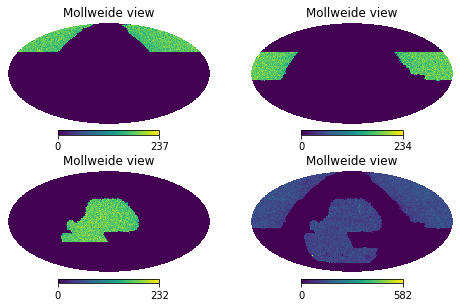

220543
0 galdepth_g
1 galdepth_r
2 galdepth_z
3 psfsize_g
4 psfsize_r
5 psfsize_z
6 ebv
7 stardens
(786432, 9)
[ 1.19961656e+00 -6.75444635e-05 -8.21827729e-05  1.97264534e-04
 -2.91519423e-03  8.67837589e-02 -1.10506104e-01  3.25025266e-01
 -6.28274887e-05]


In [3]:
'''
    read 
'''
elg  = ft.read('/home/mehdi/data/DESIashley/ELGtargetinfo.fits', lower=True)
ran  = ft.read('/home/mehdi/data/DESIashley/ELGrandoms.fits',    lower=True)
pixw = ft.read('/home/mehdi/data/pixweight-dr8-0.31.1.fits',     lower=True)
mzls, dnorth, dsouth = splitcat(ran)

    
'''
    Make the masks

'''
hmzls   = ut.hpixsum(256, mzls['ra'], mzls['dec'])
hdnorth = ut.hpixsum(256, dnorth['ra'], dnorth['dec'])
hdsouth = ut.hpixsum(256, dsouth['ra'], dsouth['dec'])
helg    = ut.hpixsum(256, elg['ra'], elg['dec'])

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))
ax = ax.flatten()
for i,mmi in enumerate([hmzls, hdnorth, hdsouth, helg]):
    fig.sca(ax[i])
    hp.mollview(mmi, hold=True)
plt.show()

    
'''
    Create the binary mask

'''
hfull = hdnorth + hdsouth #+ hmzls

maskn = hdnorth > 0
masks = hdsouth > 0
maskm = hmzls   > 0
mask  = hfull > 0 # or (hdnorth > 0) | (hdsouth > 0) | (hmzls > 0)
print(mask.sum())   



'''
    Read imaging maps in Ring order
    

'''
colnames = [ 'galdepth_g',
             'galdepth_r',
             'galdepth_z',
             'psfsize_g',
             'psfsize_r',
             'psfsize_z',
             'ebv', 
             'stardens']

sysmaps = {}
for j, col_j in enumerate(colnames):
    print(j, col_j)
    sysmaps[col_j] = hp.reorder(pixw[col_j], n2r=True)
    
    
'''
    compute mean density

'''    
# names = ['full', 'north', 'south']
# results = {}
# for j, col_j in enumerate(colnames):
#     print(col_j)
#     sys_j = hp.reorder(pixw[col_j], n2r=True)
#     result_j = {}
#     for i,mask_i in enumerate([mask, maskn, masks]):
#         print(i, names[i])
#         NNbar = nnbar.NNBAR(helg, hfull, mask_i, sys_j, nbins=8)
#         NNbar.run(njack=10)
#         arrays = (NNbar.output['bin_edges'][:-1], NNbar.output['nnbar'], NNbar.output['nnbar_err'])    
#         result_j[names[i]] = arrays
#     results[col_j] = result_j    

    
# fig, ax = plt.subplots(ncols=4, nrows=2,
#                        figsize=(20, 10), sharey=True)
# ax = ax.flatten()
# for j, key_j in enumerate(results.keys()):
#     sys_j = results[key_j]
#     for i, cap_i in enumerate(sys_j.keys()):
#         mycap = sys_j[cap_i]
#         ax[j].errorbar(*mycap, marker='o',
#                        label='{0:6s} {1:5.1f}'\
#                        .format(cap_i, rmse(*mycap)))
#     ax[j].legend()
#     ax[j].grid(True)
#     ax[j].set(xlabel=key_j)  


label  = ut.makedelta(helg, hfull, mask) + 1
arrays = [np.ones(12*256*256)] + [sysmaps[k] for k in sysmaps.keys()]
       #+ [sysmaps[k]*sysmaps[k] for k in sysmaps.keys()]
       #+ [sysmaps[k]*sysmaps[k]*sysmaps[k] for k in sysmaps.keys()]\
       #+ [sysmaps[k]*sysmaps[k]*sysmaps[k]*sysmaps[k] for k in sysmaps.keys()]\
       #+ [sysmaps[k]*sysmaps[k]*sysmaps[k]*sysmaps[k]*sysmaps[k] for k in sysmaps.keys()]
Y = label
X = np.column_stack(arrays)
print(X.shape)

Lin = linfit(X[mask], Y[mask])
print(Lin.popt)


wt = model(X[:,:], *Lin.popt)

0 full
1 north
2 south
0 full
1 north
2 south


Text(0, 0.5, 'N/Nbar')

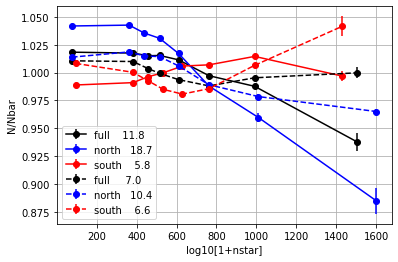

In [6]:
names = ['full', 'north', 'south']
c = ['k', 'b', 'r']
lt = ['-', '--', '-.']
for j,wt_i in enumerate([np.ones_like(wt), wt]):
    
    results = {}
    for i,mask_i in enumerate([mask, maskn, masks]):
        print(i, names[i])
        NNbar = nnbar.NNBAR(helg.astype('f8'), hfull.astype('f8'), mask_i, sysmaps['stardens'], 
                            selection=wt_i, nbins=8)
        NNbar.run(njack=10)
        results[names[i]] = (NNbar.output['bin_edges'][:-1], 
                             NNbar.output['nnbar'], NNbar.output['nnbar_err'])

    for i,name_i in enumerate(results.keys()):
        myr = results[name_i]
        plt.errorbar(*myr, marker='o',
                     label='{0:6s} {1:5.1f}'\
                           .format(name_i, rmse(*myr)),
                    color=c[i], ls=lt[j])
plt.legend()
plt.grid()
plt.xlabel('log10[1+nstar]')
plt.ylabel('N/Nbar')

In [7]:
sysmaps2 = pd.read_hdf('/home/mehdi/data/dr8_combined256.h5')

In [8]:
from LSSutils.catalogs.datarelease import cols_dr8

In [22]:
mask3 = (np.isnan(X2).sum(axis=1)==0)
mask2 = mask & mask3

In [57]:
sysmaps2['nstar'] = sysmaps['stardens'].copy()

In [58]:
arrays2 = [np.ones(12*256*256)] + [sysmaps2[k] for k in cols_dr8]
#        + [sysmaps2[k]*sysmaps2[k] for k in cols_dr8]
       #+ [sysmaps[k]*sysmaps[k]*sysmaps[k] for k in sysmaps.keys()]\
       #+ [sysmaps[k]*sysmaps[k]*sysmaps[k]*sysmaps[k] for k in sysmaps.keys()]\
       #+ [sysmaps[k]*sysmaps[k]*sysmaps[k]*sysmaps[k]*sysmaps[k] for k in sysmaps.keys()]

X2 = np.column_stack(arrays2)
print(X2.shape)

Lin2 = linfit(X2[mask2], Y[mask2])
print(Lin2.popt)


wt2 = model(X2[:,:], *Lin2.popt)

(786432, 22)
[ 4.42836868e+00  1.04739552e+00 -2.82304967e-01 -3.26446561e-05
 -8.46314803e-02 -3.92942442e-03  5.50353866e-02  6.20769274e-02
  6.95454458e-03  1.63100529e-02 -2.74891777e-03  4.62100561e-02
 -2.55383853e-02  3.76007928e-03  1.89752543e-02  1.21714736e-02
  3.34639804e-06 -6.02402449e-07 -1.23195298e-06 -1.34106769e-05
  1.29363377e-05  3.90787868e-05]


0 full 219280
1 north 110487
2 south 108793
0 full 219280
1 north 110487
2 south 108793
0 full 219280
1 north 110487
2 south 108793


(0.9, 1.1)

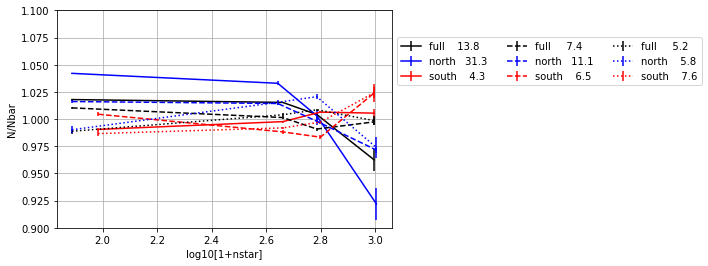

In [63]:
names = ['full', 'north', 'south']
c = ['k', 'b', 'r']
lt = ['-', '--', ':']
for j,wt_i in enumerate([np.ones_like(wt), wt, wt2]):
    
    results = {}
    for i,mask_i in enumerate([mask, maskn, masks]):
        np.random.seed(123456)
        mask_j = mask_i & mask3
        print(i, names[i], mask_j.sum())
        NNbar = nnbar.NNBAR(helg.astype('f8'), hfull.astype('f8'), mask_j, 
                            np.log10(1+sysmaps['stardens']), 
                            selection=wt_i, nbins=4)
        NNbar.run(njack=10)
        results[names[i]] = (NNbar.output['bin_edges'][:-1], 
                             NNbar.output['nnbar'], NNbar.output['nnbar_err'])

    for i,name_i in enumerate(results.keys()):
        myr = results[name_i]
        plt.errorbar(*myr,
                     label='{0:6s} {1:5.1f}'\
                           .format(name_i, rmse(*myr)),
                    color=c[i], ls=lt[j])
plt.legend(bbox_to_anchor=(1., 0.9), ncol=3)
plt.grid()
plt.xlabel('log10[1+nstar]')
plt.ylabel('N/Nbar')
plt.ylim(0.9, 1.1)

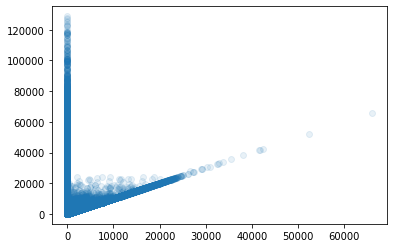

In [56]:
plt.scatter(sysmaps2['nstar'], sysmaps['stardens'], alpha=0.1)

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


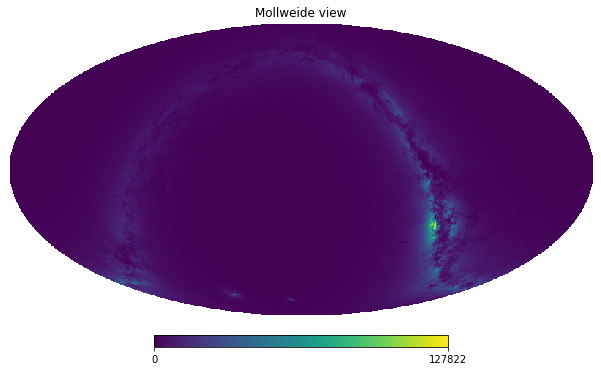

In [55]:
hp.mollview(sysmaps['stardens'])